# Prediction decomposition

In this notebook, we decompose the GRACE-era predictions (validation and test partitions) and analyze the correlation of trend and residual with GRACE.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.metrics import r2_score

import deepwaters  # noqa
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR, month_center_range
from deepwaters.visualization import plot_basinwise_map

# Register dask progress bar
ProgressBar(minimum=5).register()


In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"


Open model predictions:

In [3]:
# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"

pred_zarrs = [
    pred_dir / "ensemble_alltrain_10folds_combined.zarr",
]
preds = xr.merge([xr.open_zarr(store) for store in pred_zarrs])


In [4]:
target_var = "twsa_csr"

Get target, WaterGAP and land mask:

In [5]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)


In [6]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
gap = inps.twsa_gap
true = tgts[target_var]


Merge everything:

In [7]:
mgd = xr.merge([true, gap, preds, recs])
# Apply mask
mgd = mgd.where(mask == 1)
mgd


<xarray.Dataset> Size: 29GB
Dimensions:                                    (time: 1480, lat: 360, lon: 720)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float64 6kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/19)
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gap                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    ...                                         ...
    yin_csr_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_csr_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_full                              (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill                          (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

Define more readable variable names:

In [8]:
vars_verbose = {
    "twsa_csr": "CSR-M (ground truth)",
    "pred_ensemble_alltrain_gap_lnll_latest": "Ours, w/ WGHM",
    "pred_ensemble_alltrain_nogap_lnll_latest": "Ours, w/o WGHM",
    "twsa_gap": "WaterGAP (WGHM)",
    "humphrey_gsfc_detrend": "Humphrey's GSFC REC",
    "li_csr_full": "Li's CSR REC",
    "yin_csr_full": "Yin's CSR REC",
}


In [9]:
eval_vars = list(vars_verbose.keys())
eval_vars.remove(target_var)


## Trends and amplitudes during GRACE era

In [10]:
# Select variables
mgd = mgd[[*eval_vars, target_var]]

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = mgd.sel(time=baseline).mean("time")
anomaly = mgd - base_mean

# Only evaluate GRACE time
anom_gracetime = anomaly.sel(time=slice("2002-04", "2021-12"))
print(len(anom_gracetime.time))
# Remove missing time steps - remove missing time steps in GRACE for all vars?
# anom_gracetime = anomaly.where(anomaly.dw.time_notnull(), drop=True)
# print(len(anom_gracetime.time))


# Dims: ("model", "region")
basin_avg: xr.Dataset = (
    # Basins over 200,000 km²
    anom_gracetime.dw.select_basins(top=72).dw.weight_lat().mean(["lat", "lon"])
).compute()


237
[########################################] | 100% Completed | 79.69 s


In [11]:
# Convert to data arrays
da_grid = anom_gracetime.to_dataarray("model")
da_basin = basin_avg.to_dataarray("model")


### Perform linear trend / multi-seasonal decomposition

We use the following function to approximate the constant $a$, the linear trend $m$, and the annual and semi-annual sinusoidal curves:

$$
y(t) = a + m \, t + c \, \sin(2π  \, t) + d \, \cos(2π \, t) + e \, \sin(4π \, t) + f \cos(4π \, t) + r
$$

In [12]:
YEAR_NS = 365.25 * 24 * 60 * 60 * 1e9


def decomp_func(
    t: np.ndarray, a: float, b: float, c: float, d: float, e: float, f: float
) -> np.ndarray:
    # Convert t from nanosecons to years
    t = t / YEAR_NS

    linear = a + b * t
    annual = c * np.sin(2 * np.pi * t) + d * np.cos(2 * np.pi * t)
    semian = e * np.sin(4 * np.pi * t) + f * np.cos(4 * np.pi * t)

    return linear + annual + semian


In [13]:
# Apply decomposition
# Curvefit skips missing values per default
fit = da_basin.curvefit("time", decomp_func)


Evaluate result:

In [14]:
# Only perform analysis on GRACE TWSA and Congo
csr = tgts.twsa_csr
twsa_congo_orig = (
    csr.dw.select_basins("Congo", return_region=False)
    .dw.weight_lat()
    .mean(["lat", "lon"])
)

# Obtain curvefit coefficients
fit_coeff = twsa_congo_orig.curvefit("time", decomp_func).curvefit_coefficients
# Create time series without missing values
time_csr = twsa_congo_orig.get_index("time")
time_full = month_center_range(time_csr[0], time_csr[-1])
# # Convert time stamps to nanoseconds
t = time_full.values.astype(float)
twsa_congo_linrec = decomp_func(t, *fit_coeff.values)
# # Create a data array from it
twsa_congo_linrec = xr.DataArray(
    twsa_congo_linrec, dims=["time"], coords={"time": time_full}, name="twsa_csr_linrec"
)


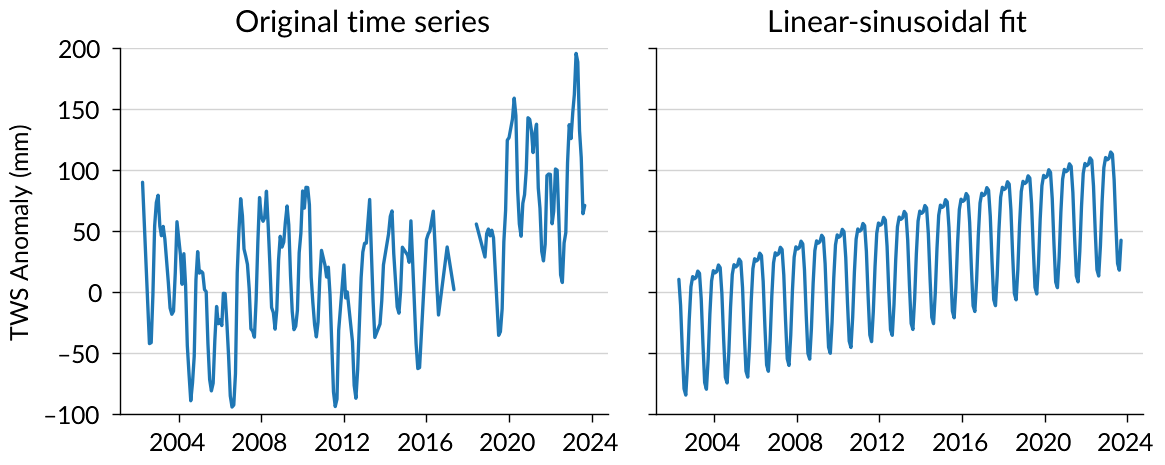

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 2.5), sharex=True, sharey=True)
ax1, ax2 = ax
ax1.plot(twsa_congo_orig.time, twsa_congo_orig)
ax2.plot(twsa_congo_linrec.time, twsa_congo_linrec)
ax1.set(ylim=(-100, 200), title="Original time series", ylabel="TWS Anomaly (mm)")
ax2.set(title="Linear-sinusoidal fit")
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

fig.savefig(FIGURE_DIR / "decomp_congo.pdf", backend="pgf")


### Calculate slope and amplitudes

In [16]:
# Linear trend: mm / yr
lintrend = fit.curvefit_coefficients.sel(param="b")

lintrend.attrs = {"long_name": "Trend", "unit": "mm / yr"}


Calculate annual amplitude:

$$
A = \sqrt{c^2 + d^2}
$$

In [17]:
c = fit.curvefit_coefficients.sel(param="c")
d = fit.curvefit_coefficients.sel(param="d")
e = fit.curvefit_coefficients.sel(param="e")
f = fit.curvefit_coefficients.sel(param="f")

amp_annual = np.sqrt(c**2 + d**2)
amp_semian = np.sqrt(e**2 + f**2)

amp_annual.attrs = {"long_name": "Annual amplitude", "unit": "mm"}
amp_semian.attrs = {"long_name": "Semi-annual amplitude", "unit": "mm"}


### Map plots

In [18]:
# Get timespan
start = da_basin.get_index("time")[0]
end = da_basin.get_index("time")[-1]
timespan_str = f"{start.year}-{start.month:02} - {end.year}-{end.month:02}"
timespan_str


'2002-04 - 2021-12'

In [19]:
basin_shapes = basins(top=72)

plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    rasterized=True,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    rasterized=True,
)
title_kwargs = dict(fontsize=16, weight="bold")


In [20]:
print(f"{lintrend.max() = :.2f}")
print(f"{lintrend.min() = :.2f}")


lintrend.max() = 10.96
lintrend.min() = -27.60


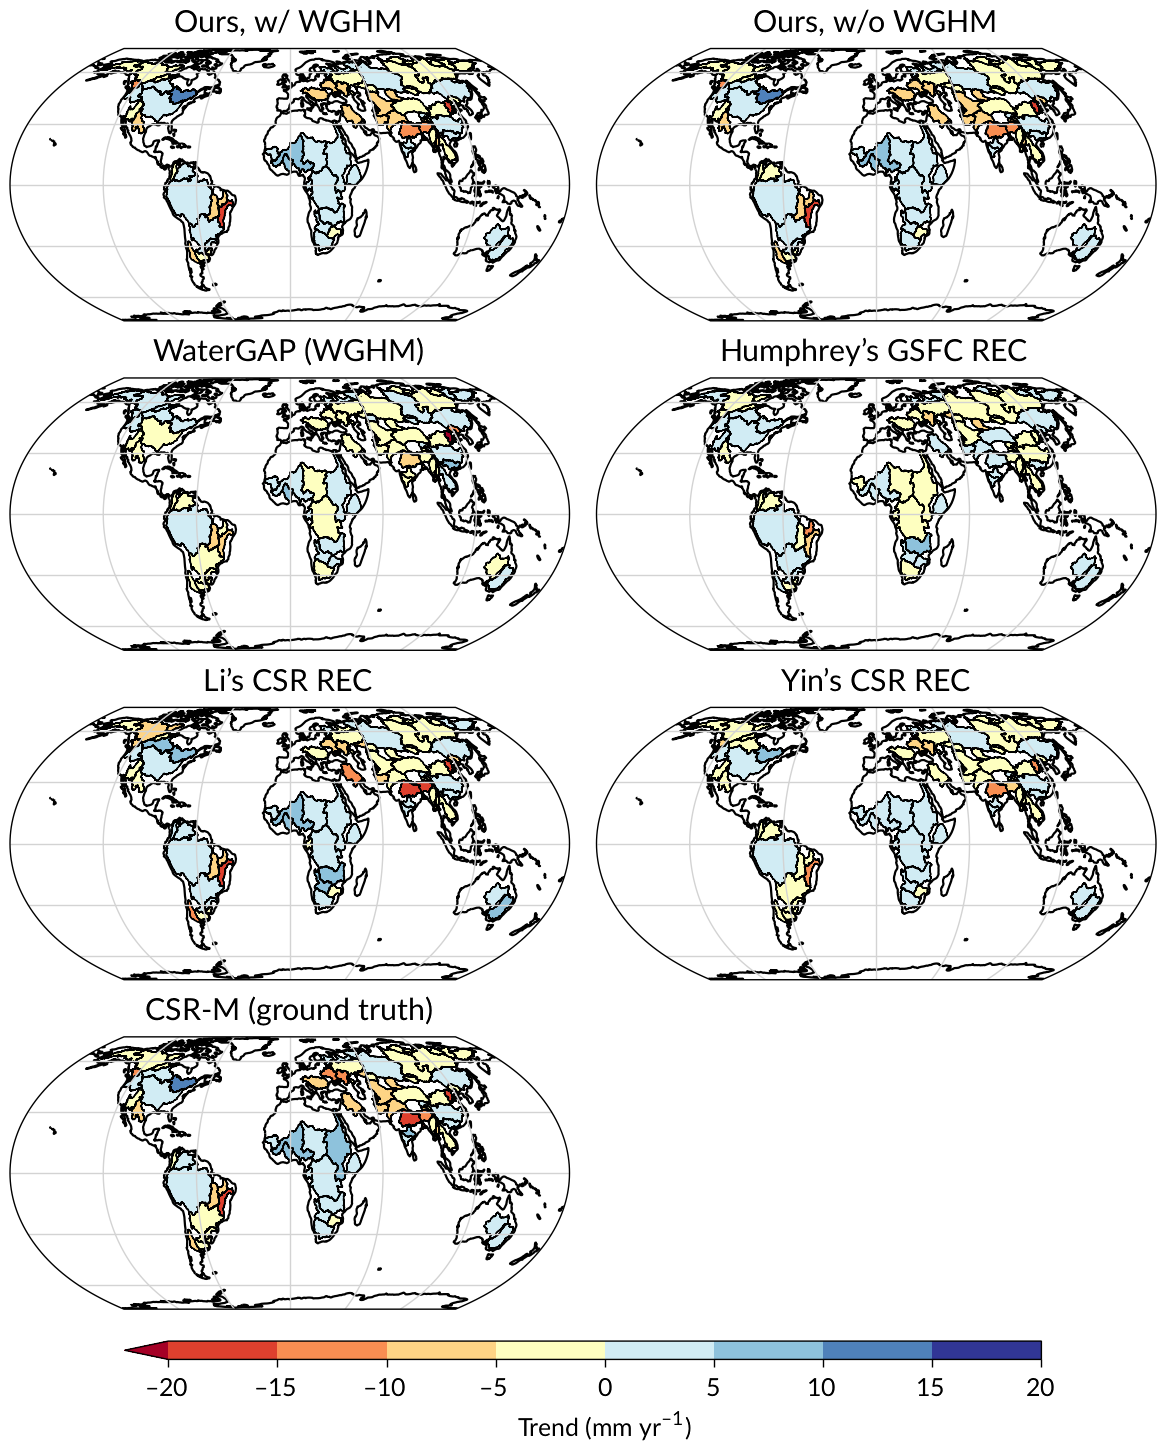

In [21]:
plot_kwargs["cbar_kwargs"]["label"] = r"Trend (mm yr$^{-1}$)"

p = plot_basinwise_map(
    lintrend,
    da_grid,
    col="model",
    vmin=-20,
    levels=9,
    cmap="RdYlBu",
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, lintrend.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "decomp_grace-era_trend.pdf", backend="pgf")


In [22]:
print(f"{amp_annual.max() = :.2f}")
print(f"{amp_annual.min() = :.2f}")


amp_annual.max() = 226.76
amp_annual.min() = 3.81


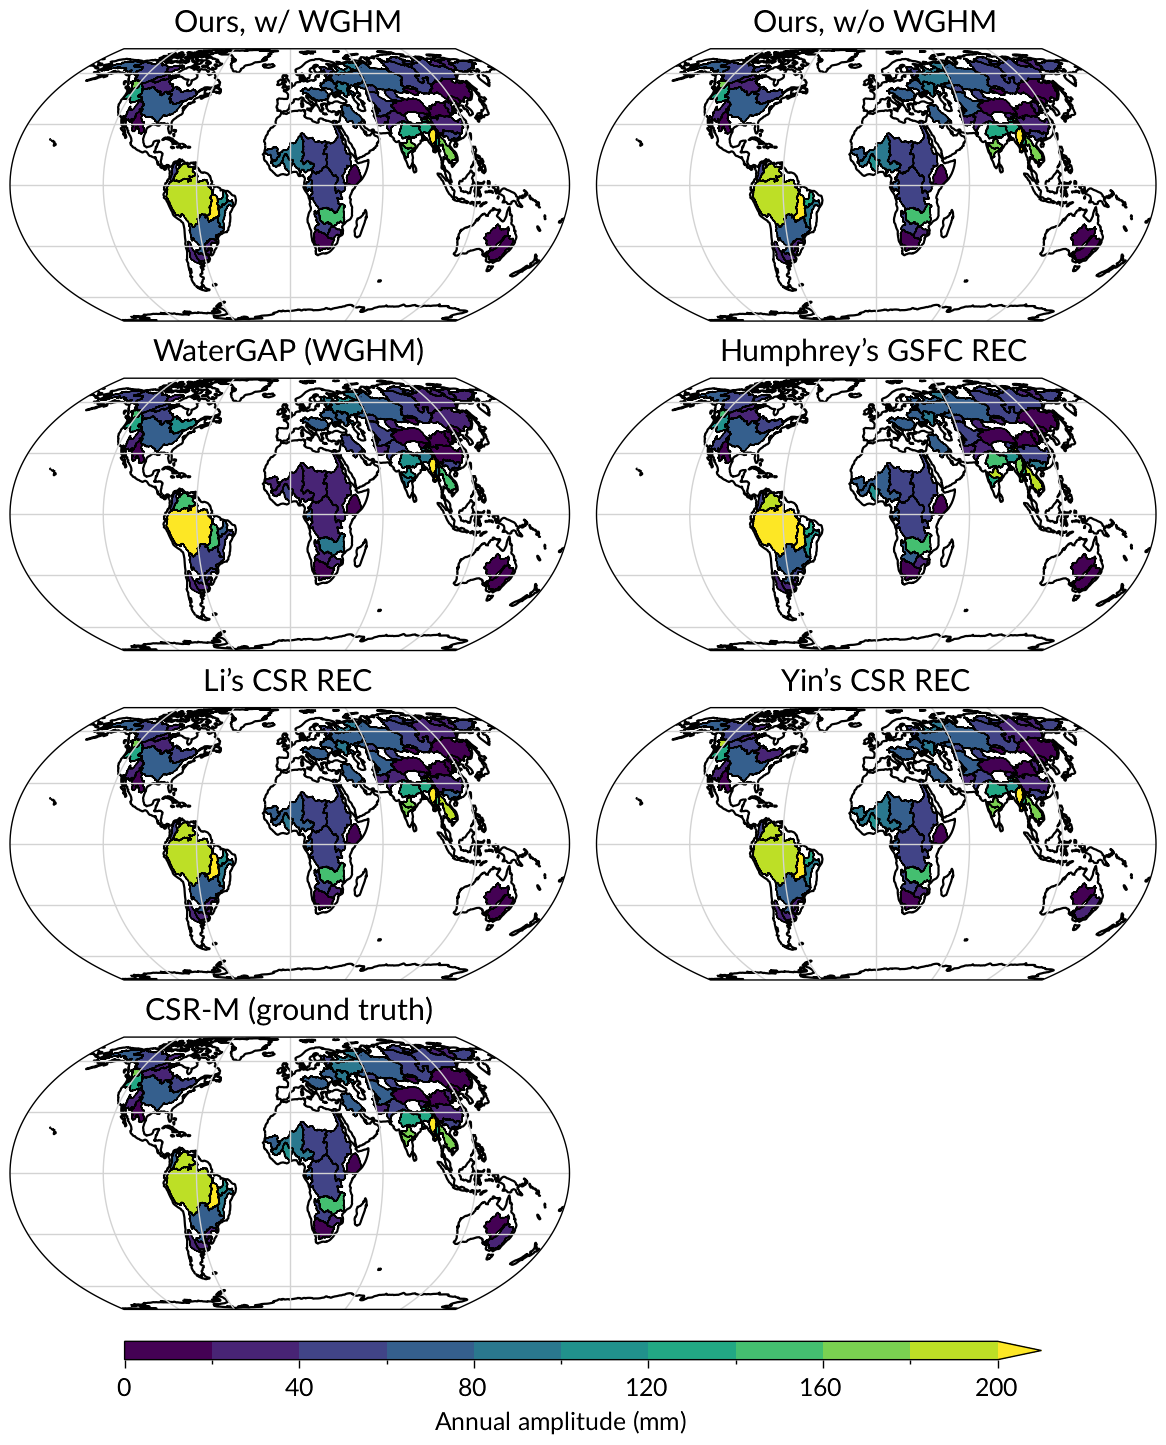

In [23]:
plot_kwargs["cbar_kwargs"]["label"] = "Annual amplitude (mm)"

p = plot_basinwise_map(
    amp_annual,
    da_grid,
    col="model",
    cmap="viridis",
    vmin=0,
    vmax=200,
    levels=11,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, amp_annual.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-annual.pdf", backend="pgf")


In [24]:
print(f"{amp_semian.max() = :.2f}")
print(f"{amp_semian.min() = :.2f}")


amp_semian.max() = 64.87
amp_semian.min() = 0.30


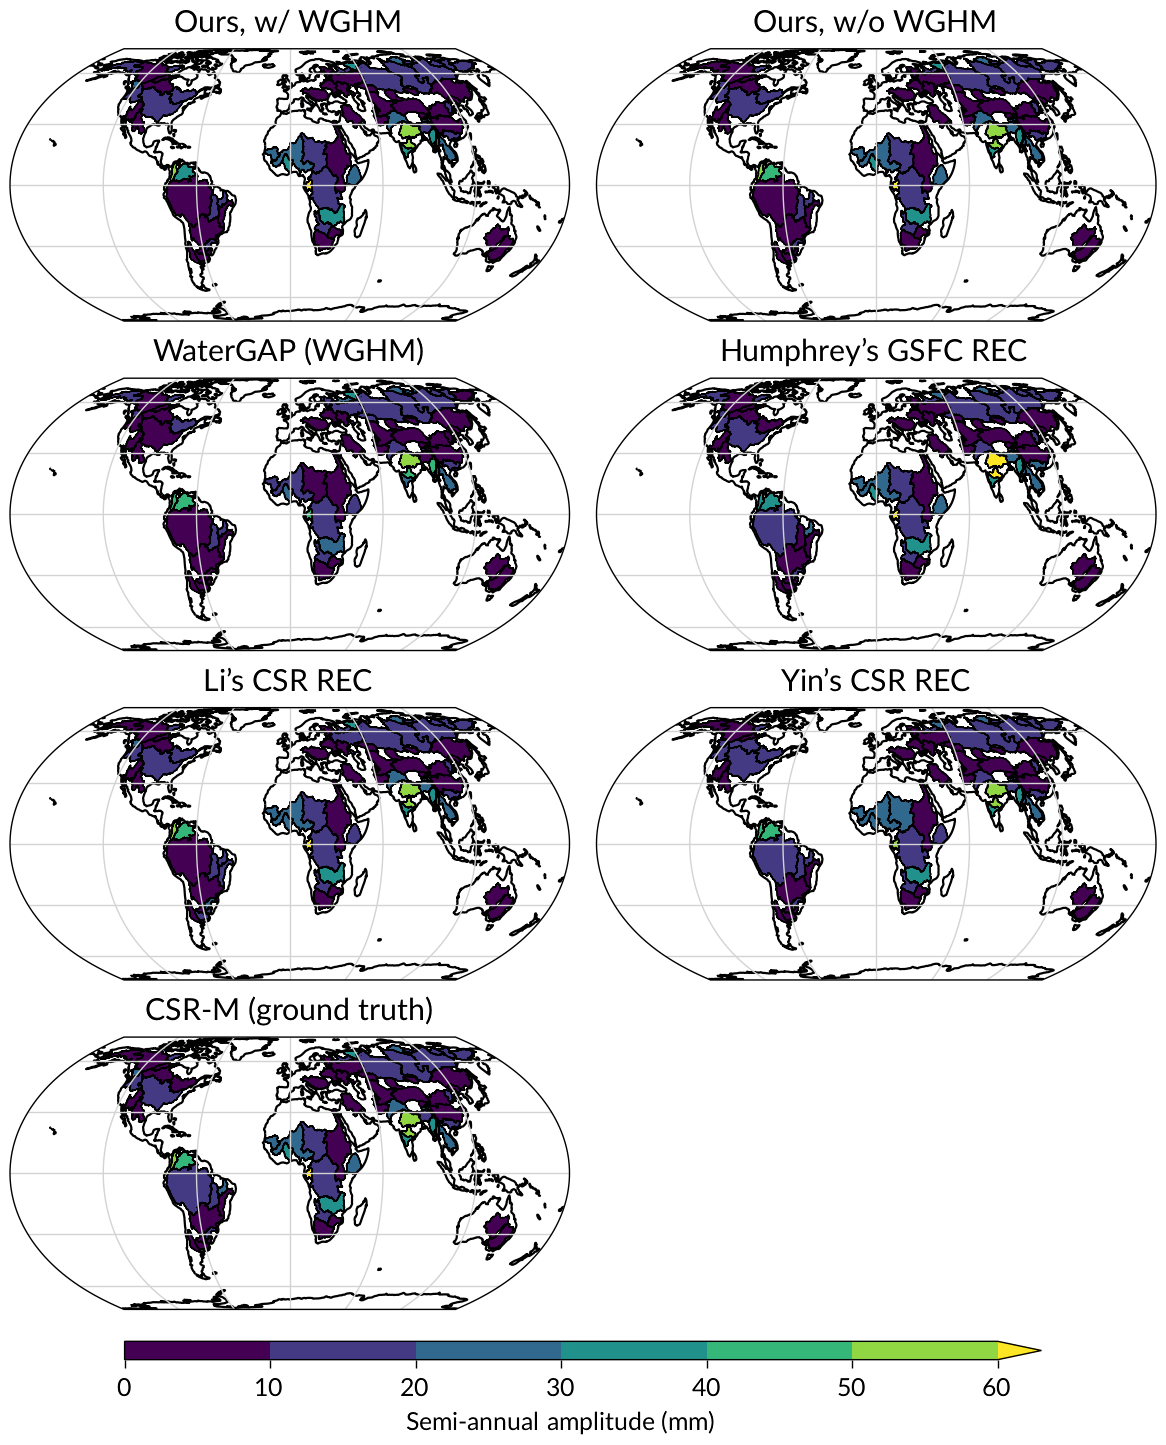

In [25]:
plot_kwargs["cbar_kwargs"]["label"] = "Semi-annual amplitude (mm)"

p = plot_basinwise_map(
    amp_semian,
    da_grid,
    col="model",
    cmap="viridis",
    vmin=0,
    vmax=60,
    levels=7,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, amp_semian.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-semiannual.pdf", backend="pgf")


### Scatter plots

In [26]:
basin_sizes = basin_shapes[["river", "sum_sub_ar"]].rename(
    columns={"river": "region", "sum_sub_ar": "area"}
)
# km² to M km³
basin_sizes.area /= 1e6


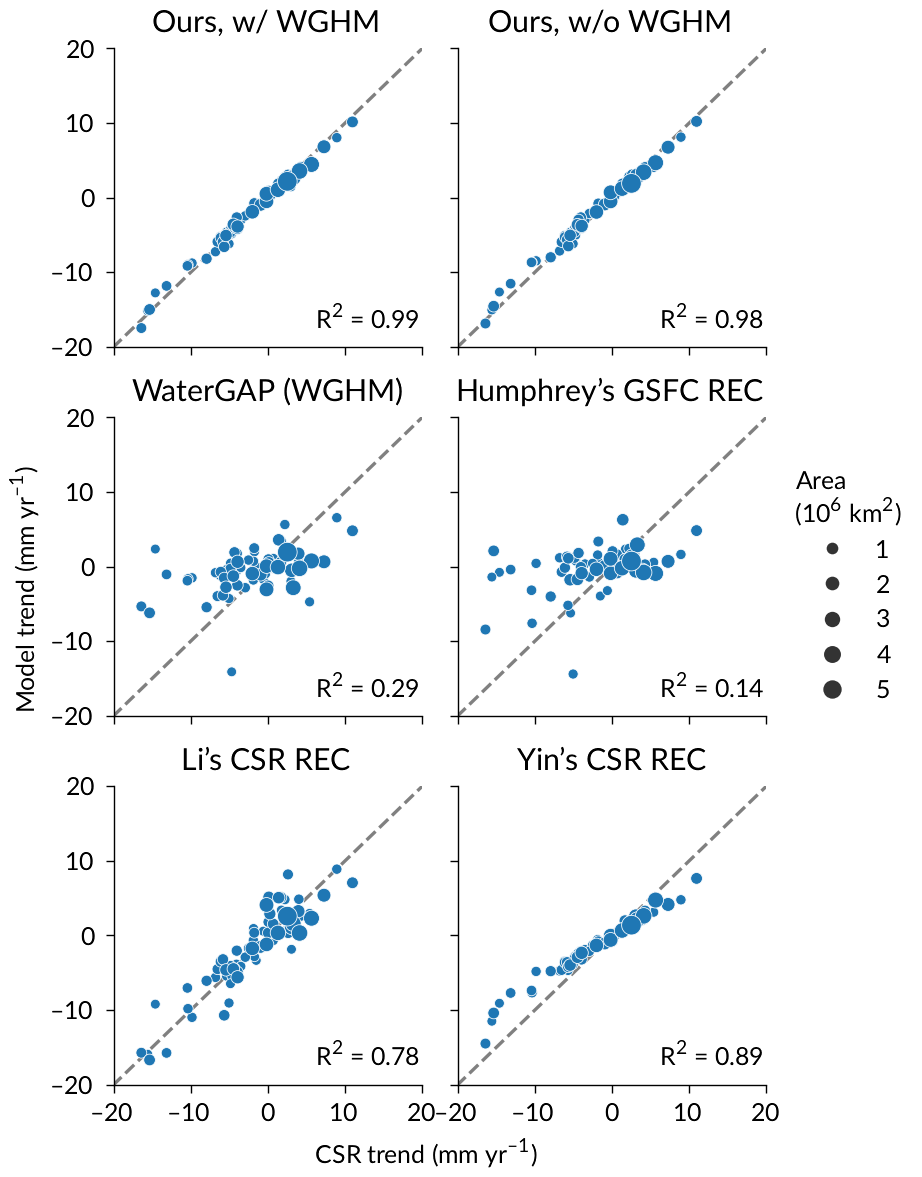

In [27]:
LIM_L = -20
LIM_U = 20
locator = ticker.MultipleLocator(10)

df_rel = (
    lintrend.to_pandas()
    .transpose()
    .reset_index()
    .merge(basin_sizes, on="region")
    .melt(
        id_vars=["region", target_var, "area"],
        value_name="twsa_model",
        var_name="model",
    )
    # Sort after area so large basins are printed lastly
    .sort_values("area")
)
df_rel.model = pd.Categorical(df_rel.model, categories=eval_vars, ordered=True)

p = sns.relplot(
    df_rel,
    x=target_var,
    y="twsa_model",
    col="model",
    size="area",
    col_wrap=2,
    height=2,
    aspect=1,
)

for ax, model in zip(p.axes.flat, df_rel.model.cat.categories):
    ax.plot(
        [LIM_L - 10, LIM_U + 10],
        [LIM_L - 10, LIM_U + 10],
        color="gray",
        linestyle="dashed",
        zorder=0,
    )
    # Add Pearson's correlation coeff
    df_model = df_rel[df_rel.model == model]
    r2 = r2_score(
        df_model[target_var], df_model["twsa_model"], sample_weight=df_model["area"]
    )
    ax.text(
        1.0, 0.05, f"R$^2$ = {r2 :.2f}", ha="right", va="bottom", transform=ax.transAxes
    )

    ax.set(
        title=vars_verbose[model],
        xlim=(LIM_L, LIM_U),
        ylim=(LIM_L, LIM_U),
        xlabel=None,
        ylabel=None,
    )
sns.move_legend(
    p,
    title="Area\n" + r"($10^6$ km$^2$)",
    loc="center right",
    bbox_to_anchor=(1.05, 0.5),
)
# Set common labels
p.figure.text(0.5, 0.04, "CSR trend (mm yr$^{-1}$)", ha="center", va="top")
p.figure.text(
    0.07,
    0.5,
    "Model trend (mm yr$^{-1}$)",
    ha="right",
    va="center",
    rotation="vertical",
)
p.figure.savefig(FIGURE_DIR / "decomp_grace-era_trend_corr.pdf", backend="pgf")


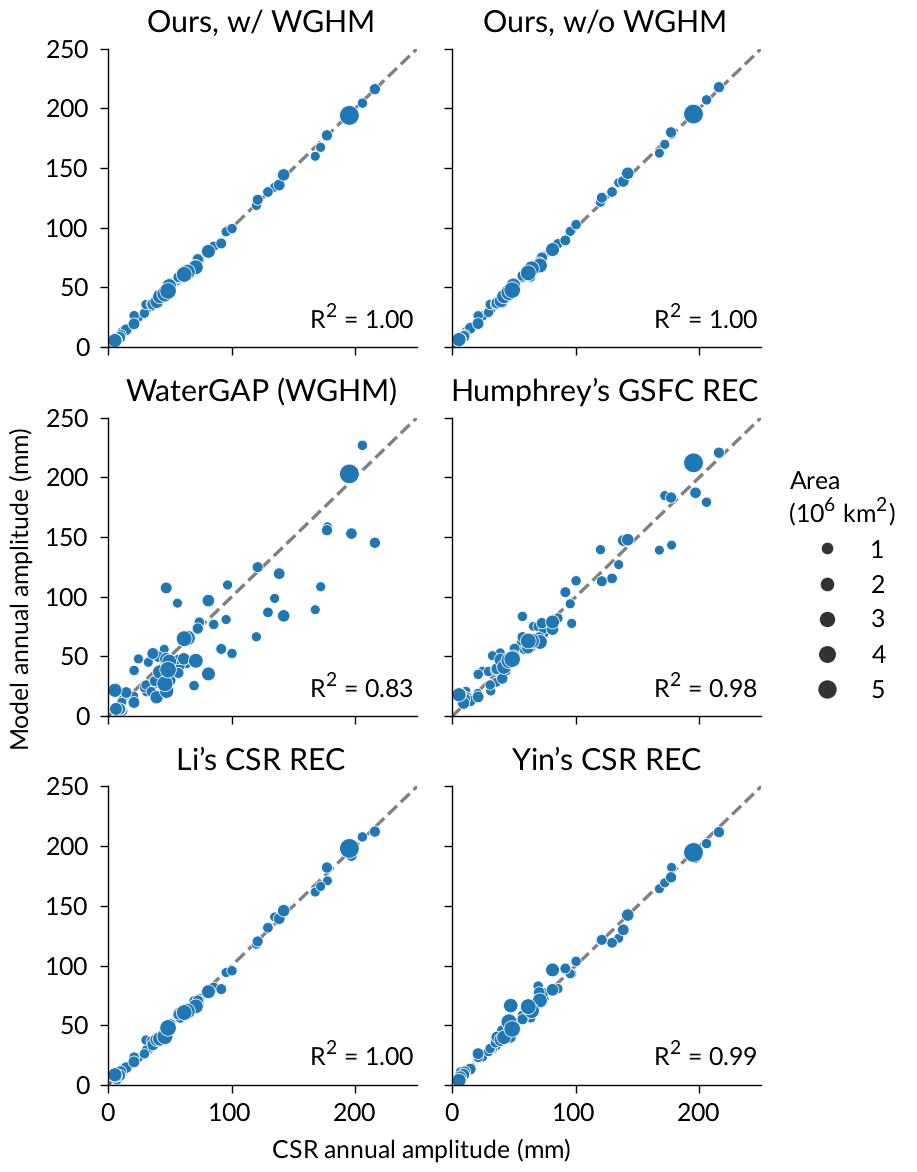

In [28]:
LIM_L = 0
LIM_U = 250
locator = ticker.MultipleLocator(50)

df_rel = (
    amp_annual.to_pandas()
    .transpose()
    .reset_index()
    .merge(basin_sizes, on="region")
    .melt(
        id_vars=["region", target_var, "area"],
        value_name="twsa_model",
        var_name="model",
    )
    # Sort after area so large basins are printed lastly
    .sort_values("area")
)
df_rel.model = pd.Categorical(df_rel.model, categories=eval_vars, ordered=True)

p = sns.relplot(
    df_rel,
    x=target_var,
    y="twsa_model",
    col="model",
    size="area",
    col_wrap=2,
    height=2,
    aspect=1,
)

for ax, model in zip(p.axes.flat, df_rel.model.cat.categories):
    ax.plot(
        [LIM_L - 10, LIM_U + 10],
        [LIM_L - 10, LIM_U + 10],
        color="gray",
        linestyle="dashed",
        zorder=0,
    )
    # Add Pearson's correlation coeff
    df_model = df_rel[df_rel.model == model]
    r2 = r2_score(
        df_model[target_var], df_model["twsa_model"], sample_weight=df_model["area"]
    )
    ax.text(
        1.0, 0.05, f"R$^2$ = {r2 :.2f}", ha="right", va="bottom", transform=ax.transAxes
    )

    ax.set(
        title=vars_verbose[model],
        xlim=(LIM_L, LIM_U),
        ylim=(LIM_L, LIM_U),
        xlabel=None,
        ylabel=None,
    )
sns.move_legend(
    p,
    title="Area\n" + r"($10^6$ km$^2$)",
    loc="center right",
    bbox_to_anchor=(1.05, 0.5),
)
# Set common labels
p.figure.text(0.5, 0.04, "CSR annual amplitude (mm)", ha="center", va="top")
p.figure.text(
    0.07,
    0.5,
    "Model annual amplitude (mm)",
    ha="right",
    va="center",
    rotation="vertical",
)
p.figure.savefig(FIGURE_DIR / "decomp_grace-era_amp-annual_corr.pdf", backend="pgf")


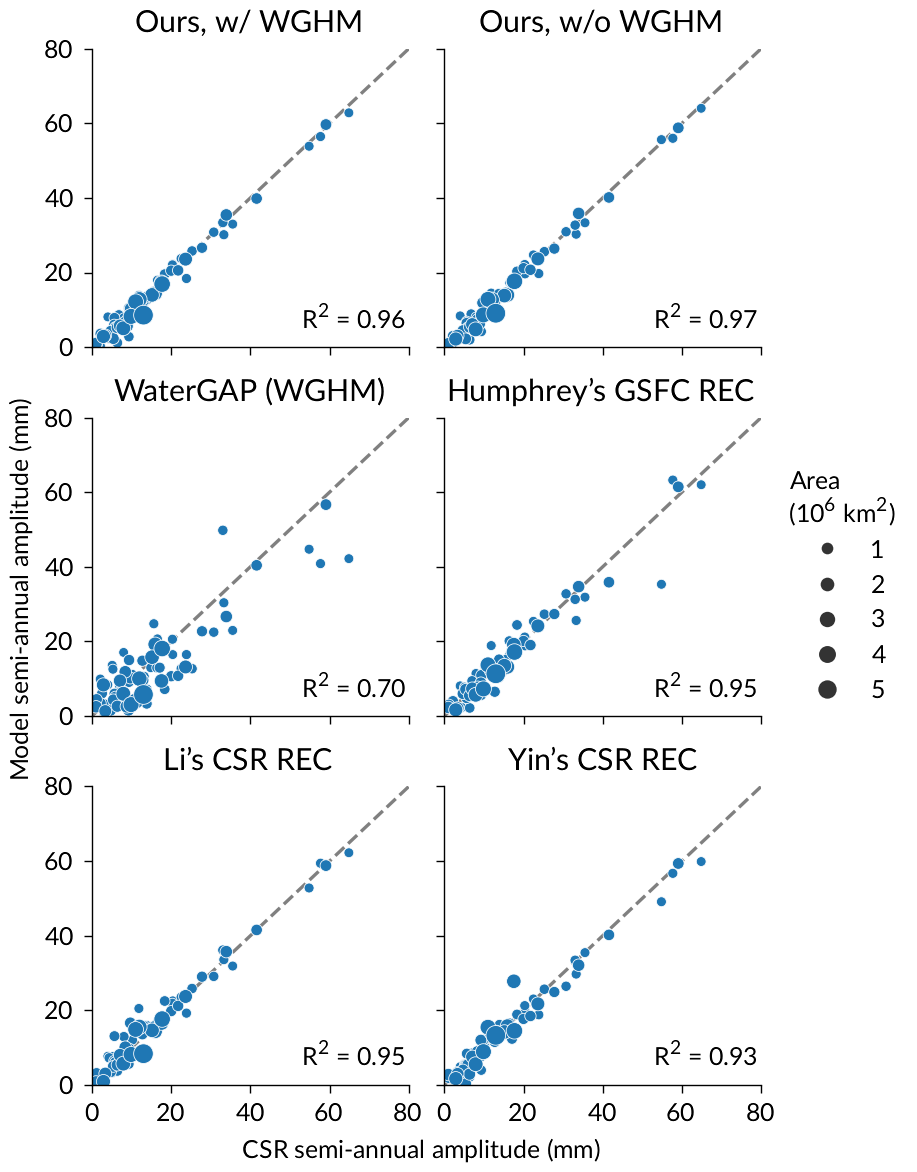

In [29]:
LIM_L = 0
LIM_U = 80
locator = ticker.MultipleLocator(25)


df_rel = (
    amp_semian.to_pandas()
    .transpose()
    .reset_index()
    .merge(basin_sizes, on="region")
    .melt(
        id_vars=["region", target_var, "area"],
        value_name="twsa_model",
        var_name="model",
    )
    # Sort after area so large basins are printed lastly
    .sort_values("area")
)
df_rel.model = pd.Categorical(df_rel.model, categories=eval_vars, ordered=True)

p = sns.relplot(
    df_rel,
    x=target_var,
    y="twsa_model",
    col="model",
    size="area",
    col_wrap=2,
    height=2,
    aspect=1,
)

for ax, model in zip(p.axes.flat, df_rel.model.cat.categories):
    ax.plot(
        [LIM_L - 10, LIM_U + 10],
        [LIM_L - 10, LIM_U + 10],
        color="gray",
        linestyle="dashed",
        zorder=0,
    )
    # Add Pearson's correlation coeff
    df_model = df_rel[df_rel.model == model]
    r2 = r2_score(
        df_model[target_var], df_model["twsa_model"], sample_weight=df_model["area"]
    )
    ax.text(
        1.0, 0.05, f"R$^2$ = {r2 :.2f}", ha="right", va="bottom", transform=ax.transAxes
    )

    ax.set(
        title=vars_verbose[model],
        xlim=(LIM_L, LIM_U),
        ylim=(LIM_L, LIM_U),
        xlabel=None,
        ylabel=None,
    )
sns.move_legend(
    p,
    title="Area\n" + r"($10^6$ km$^2$)",
    loc="center right",
    bbox_to_anchor=(1.05, 0.5),
)
# Set common labels
p.figure.text(0.5, 0.04, "CSR semi-annual amplitude (mm)", ha="center", va="top")
p.figure.text(
    0.07,
    0.5,
    "Model semi-annual amplitude (mm)",
    ha="right",
    va="center",
    rotation="vertical",
)
p.figure.savefig(FIGURE_DIR / "decomp_grace-era_amp-semiannual_corr.pdf", backend="pgf")


### Deviations

In [30]:
lintrend_diff = lintrend.sel(model=eval_vars) - lintrend.sel(model=target_var)
amp_annual_ratio = amp_annual.sel(model=eval_vars) / amp_annual.sel(model=target_var)
amp_semian_ratio = amp_semian.sel(model=eval_vars) / amp_semian.sel(model=target_var)


In [31]:
print(f"{lintrend_diff.max() = :.2f}")
print(f"{lintrend_diff.min() = :.2f}")


lintrend_diff.max() = 17.44
lintrend_diff.min() = -12.03


In [32]:
plot_kwargs["figsize"] = (6, 6.5)

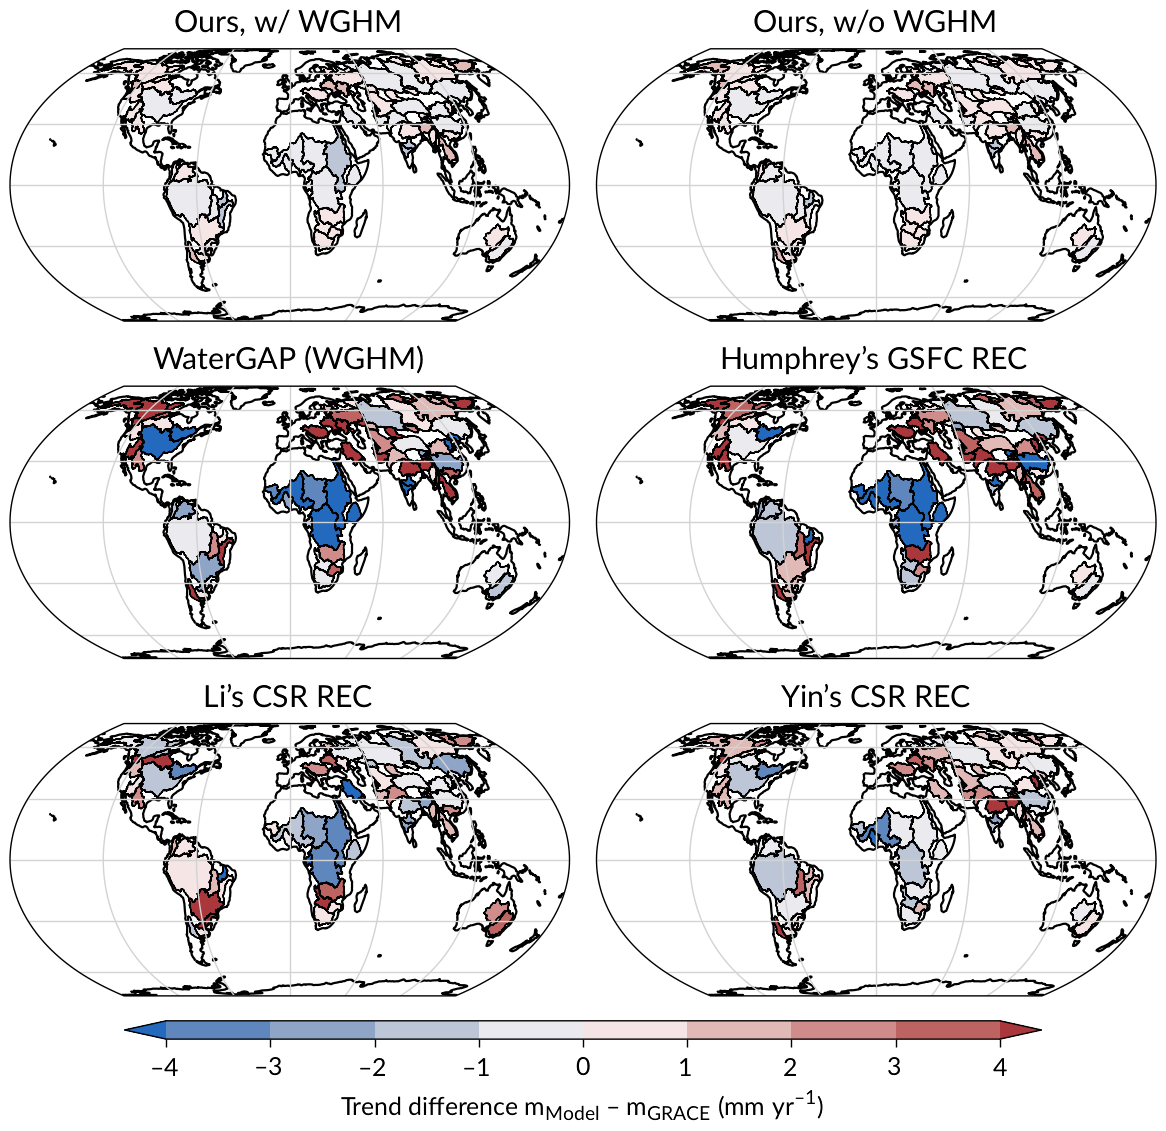

In [33]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Trend difference $m_\text{Model} - m_\text{GRACE}$ (mm yr$^{-1}$)"
)
p = plot_basinwise_map(
    lintrend_diff,
    da_grid.drop_sel(model=target_var),
    col="model",
    cmap="vlag",
    vmax=4,
    levels=9,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, lintrend.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "decomp_grace-era_trend_diff.pdf", backend="pgf")


In [34]:
print(f"{amp_annual_ratio.max() = :.2f}")
print(f"{amp_annual_ratio.min() = :.2f}")


amp_annual_ratio.max() = 4.04
amp_annual_ratio.min() = 0.37


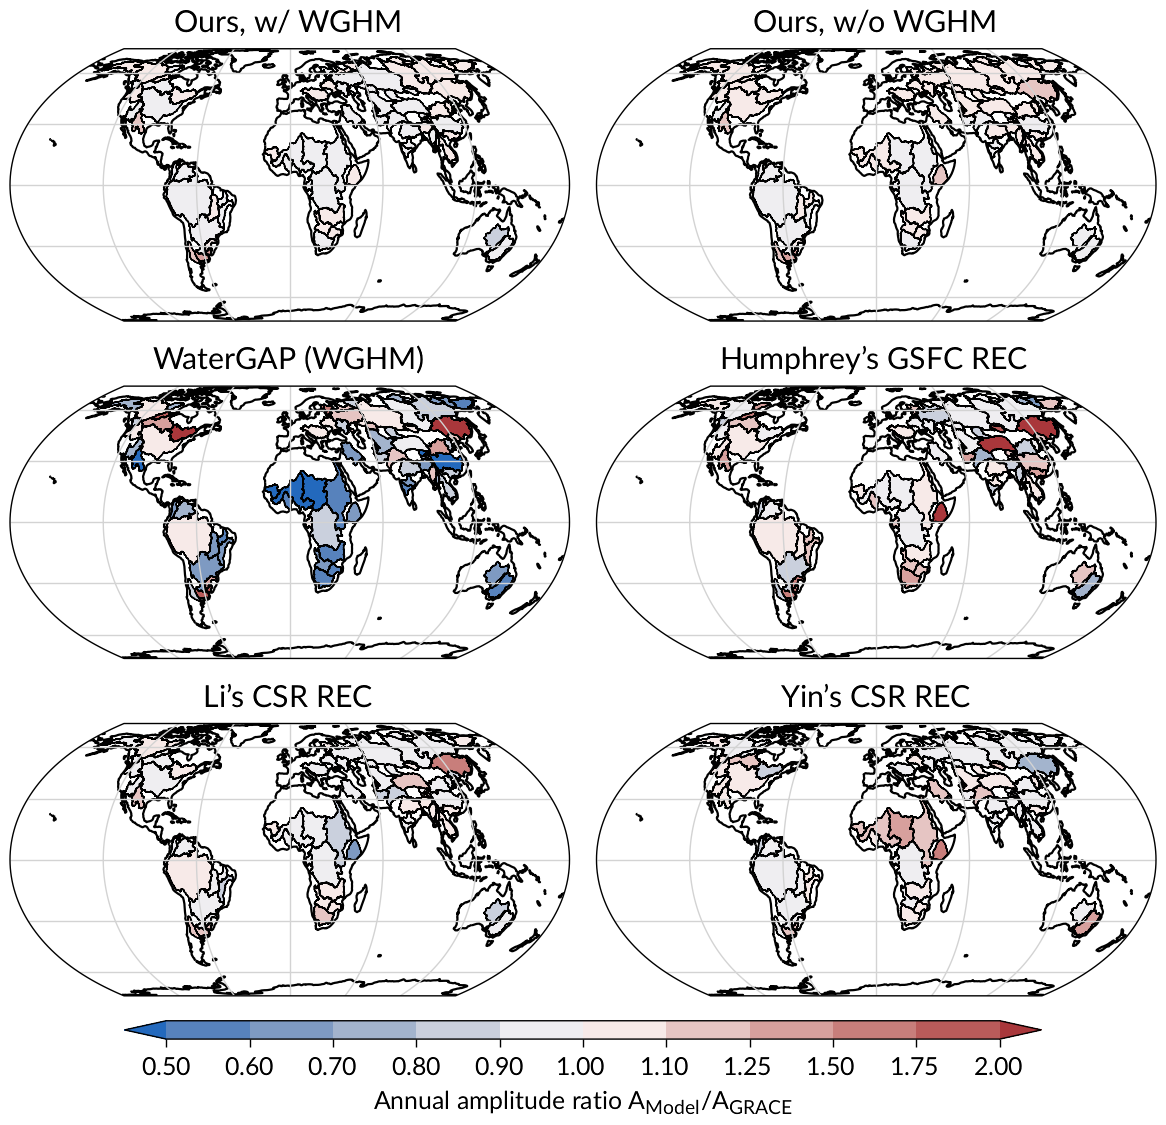

In [35]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Annual amplitude ratio $A_\text{Model} / A_\text{GRACE}$"
)
levels = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.25, 1.5, 1.75, 2.0]

plot_kwargs["cbar_kwargs"]["ticks"] = levels

p = plot_basinwise_map(
    amp_annual_ratio,
    da_grid.drop_sel(model=target_var),
    col="model",
    cmap="vlag",
    levels=levels,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, lintrend.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-annual_ratio.pdf", backend="pgf")


In [36]:
print(f"{amp_semian_ratio.max() = :.2f}")
print(f"{amp_semian_ratio.min() = :.2f}")


amp_semian_ratio.max() = 4.71
amp_semian_ratio.min() = 0.06


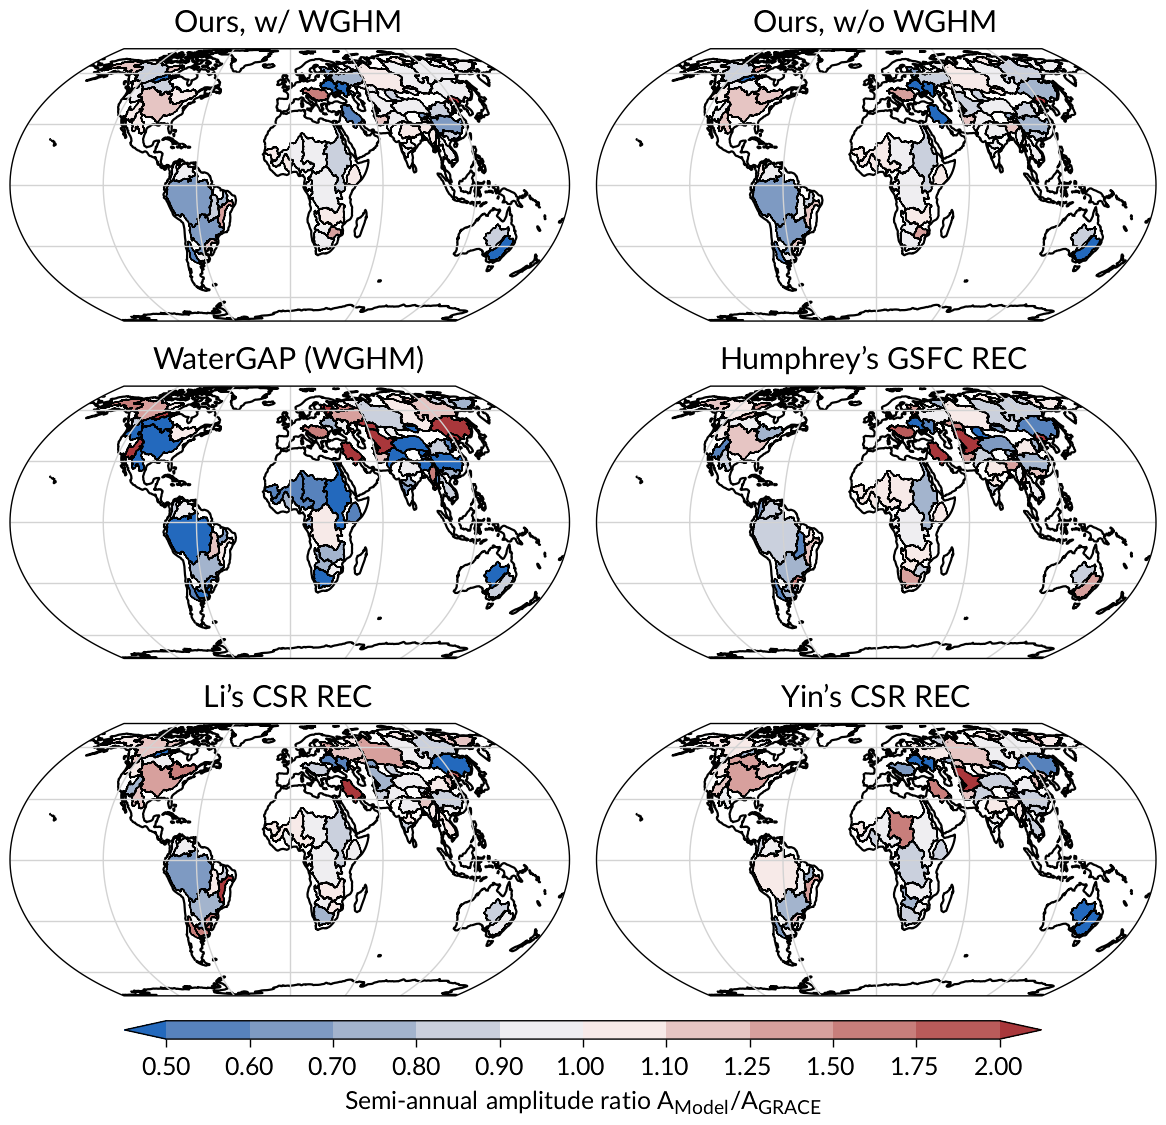

In [37]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Semi-annual amplitude ratio $A_\text{Model} / A_\text{GRACE}$"
)
plot_kwargs["cbar_kwargs"]["ticks"] = levels

p = plot_basinwise_map(
    amp_semian_ratio,
    da_grid.drop_sel(model=target_var),
    col="model",
    cmap="vlag",
    levels=levels,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, lintrend.model.values):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)
p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-semiannual_ratio.pdf", backend="pgf")
